# Truth tests with Neutrinoweighting method

Some tests of the dependency of the NW-Method of the given truth.

### Config

In [2]:
import ROOT
import matplotlib.pyplot as plt
from root_numpy import root2array, list_branches
import numpy as np
from scipy.optimize import curve_fit
from uncertainties import ufloat
import os

In [3]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['font.size'] = 16

In [4]:
inputfile = 'data/topdecayedLO.root'
filename = 'nw-truth-eta.root'

In [5]:
# helper function
def binwidth(h):
    binEdges = h[1]
    width = binEdges[1] - binEdges[0]
    return width

Create the datafile if it is not there.

In [6]:
# import os
# from subprocess import call
# if not os.path.isfile(filename):
#    call(['ls', '-lahtr'])
#    call(['./main', 'nw', '-v3', '-l10'])

In [7]:
# $ ./main truth nw -T Eta -S nw-truth-eta.root
data = root2array(filename, treename='Neutrino Weighting')
truth = root2array(filename, treename='Truth')

In [8]:
# object with [eta-sample-size][topmass-sample-size]
samples = {}
uniform_sample = {}
range = np.arange(10, 31, 10)
for x in range:
    samples[x] = {}
    uniform_sample[x] = {}
    for y in range:
        filename = "data/build/nw-seta{}-stop{}.root".format(x, y)
        if os.path.isfile(filename):
            print("found {}-{}".format(x, y))
            samples[x][y] = root2array(filename, treename="Neutrino Weighting")
        filename = "data/build/nw-seta{}uniform-stop{}.root".format(x, y)
        if os.path.isfile(filename):
            print("found {}uniform-{}".format(x, y))
            uniform_sample[x][y] = root2array(filename, treename="Neutrino Weighting")

samples.update({
    80: {
        40: root2array('data/build/nw-seta80-stop40-20150825-1737.root', treename="Neutrino Weighting")
    },
    200: {
        70: root2array('afs/dilepton/data/build/nw-seta200-stop-70-20150827-110550.root', treename="Neutrino Weighting")
    },
    1000: {
        1: root2array('tancredi/nw-seta1000-trueTopMass-noWeightCutoff-20150901-170407.root', treename="Neutrino Weighting")
    }
})

found 20-20
found 20uniform-20
found 30-10
found 30-20
found 30uniform-20


## Breit-Wigner fit

Binned quick-and-dirty breit-wigner fit to determine the input-values for the dataset.

m = 172.4945+/-0.0024
gamma = 1.554+/-0.007


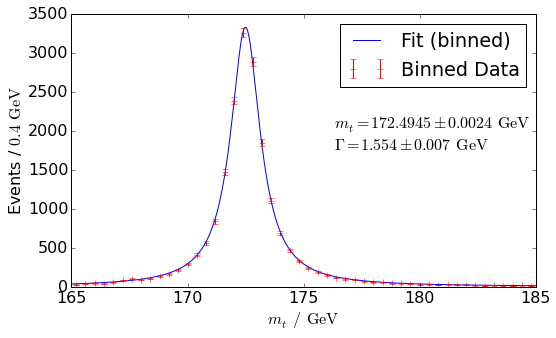

In [10]:
m_limits = (165, 185)

def breitWigner(x, M, gamma, a):
    return a / (2 * np.pi) * gamma / ((x - M)**2 + gamma**2 / 4)

def gauss(x, mu, sigma, a):
    """ define gaussian with mean mu and width sigma
    """
    return a * np.exp(-(x-mu)**2 / (2 * sigma**2)) \
            / (np.sqrt(2 * np.pi) * sigma)

h = plt.hist(truth["m"], 50, m_limits)
plt.clf()
binnedX = h[1][1:] - (h[1][1] - h[1][0]) / 2
m_pars, cov = curve_fit(breitWigner, binnedX, h[0])
errs = np.sqrt(np.diag(cov))
m_fit = ufloat(m_pars[0], errs[0])
gamma_fit = ufloat(m_pars[1], errs[1])

print("m = {}".format(m_fit))
print("gamma = {}".format(gamma_fit))

m_xs = np.linspace(165, 185, 500)
f, ax = plt.subplots()
plt.plot(m_xs, breitWigner(m_xs, *m_pars), label='Fit (binned)')
plt.errorbar(binnedX, h[0], yerr=np.sqrt(h[0]), fmt='r+', label='Binned Data')
plt.annotate('''\
$m_t = {:L}\\,\\mathrm{{GeV}}$
$\\Gamma = {:L}\\,\\mathrm{{GeV}}$\
'''.format(m_fit, gamma_fit), (176.3, 1800))
plt.legend(loc='best')
plt.ylabel(r'Events / ${}\,\mathrm{{GeV}}$'.format(binwidth(h)))
plt.xlabel(r'$m_t\,/\,\mathrm{GeV}$')
plt.tight_layout()
plt.savefig('build/plots/notebooks/truth-bw-fit.pdf')

(20000, 20000)


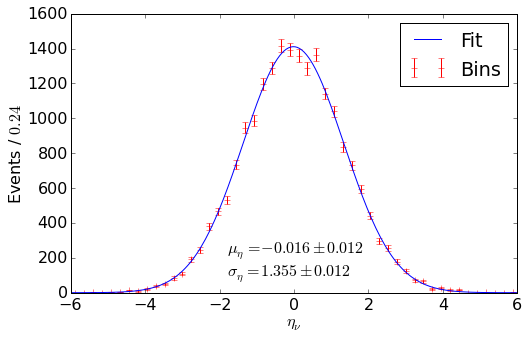

In [11]:
eta_limits = (-6, 6)
bins = 50
h = plt.hist(truth["t_neutrino_eta"], 50, eta_limits)
plt.clf()
binnedX = h[1][1:] - (h[1][1] - h[1][0]) / 2
binnedY = h[0]

eta_pars, cov = curve_fit(gauss, binnedX, binnedY)
errs = np.sqrt(np.diag(cov))
eta_fit = ufloat(eta_pars[0], errs[0])
sigma_fit = ufloat(eta_pars[1], errs[1])

eta_xs = np.linspace(-6, 6, 200)
f, ax = plt.subplots()
plt.errorbar(binnedX, binnedY, yerr=np.sqrt(binnedY), fmt="r+", label='Bins')
plt.plot(eta_xs, gauss(eta_xs, *eta_pars), label='Fit')
plt.annotate('''\
$\mu_\eta = {:L}$
$\sigma_\eta = {:L}$\
'''.format(eta_fit, sigma_fit), (-1.8, 100))
plt.xlabel(r'$\eta_\nu$')
plt.ylabel(r'Events / ${}$'.format(binwidth(h)))
plt.legend()

print(truth["t_neutrino_eta"].size, samples[30][20]["t_neutrino_eta"].size)

### Plots

####1. Result of Neutrinoweighting with gaussian distributed $\eta$-Sample and Breit-Wigner distributed $m_t$-Sample

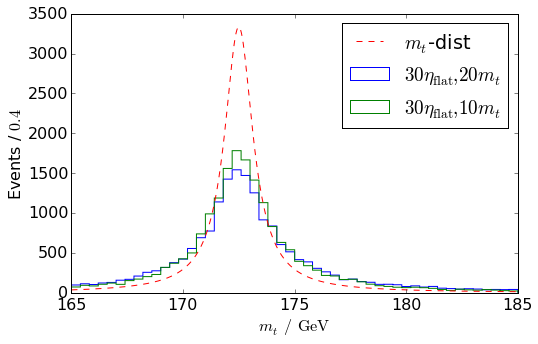

In [12]:
m_bins = 50
m_limits = (165, 185)
f, ax = plt.subplots()
h = plt.hist(samples[30][20]["m"], m_bins, m_limits, histtype="step", label=r'$30\eta_\mathrm{flat},20m_t$')
plt.hist(samples[30][10]["m"], m_bins, m_limits, histtype="step", label=r'$30\eta_\mathrm{flat},10m_t$')
plt.legend(loc='best')
plt.ylabel(r'Events / ${}$'.format(binwidth(h)))
plt.xlabel(r'$m_t\,/\,\mathrm{GeV}$')
plt.savefig('build/plots/notebooks/nw.pdf')
plt.plot(m_xs, breitWigner(m_xs, *m_pars), '--', label=r'$m_t$-dist')
plt.legend(loc='best')

#### 1.1 Comparison flat $\eta$ vs gaussian $\eta$

[array([ True,  True,  True, ...,  True,  True,  True], dtype=bool)]


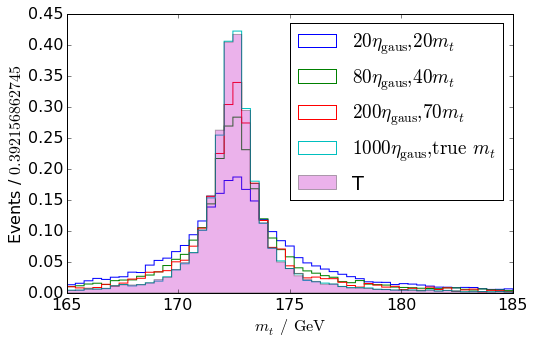

In [20]:
cuts = [(np.abs(samples[80][40]["lp_reco_id"]) < 15) & np.abs(samples[80][40]["lm_reco_id"] < 15)]
print(cuts)

f, ax = plt.subplots()
# h = plt.hist(uniform_sample[20][20]["m"], bins, m_limits, histtype="step", label=r'$20\eta_\mathrm{flat},20m_t$')
h = plt.hist(samples[20][20]["m"], bins, m_limits, histtype="step", label=r'$20\eta_\mathrm{gaus},20m_t$', normed=True)
h = plt.hist(samples[80][40]["m"], bins, m_limits, histtype="step", label=r'$80\eta_\mathrm{gaus},40m_t$', normed=True)
# h = plt.hist(samples[80][40]["m"][cuts], bins, m_limits, histtype="step", label=r'$80\eta_\mathrm{gaus},40m_t$ c', normed=True)
h = plt.hist(samples[200][70]["m"], bins, m_limits, histtype="step", label=r'$200\eta_\mathrm{gaus},70m_t$', normed=True)
h = plt.hist(samples[1000][1]["m"],
             bins, m_limits, histtype="step",
             label=r'$1000\eta_\mathrm{gaus},\mathrm{true}\,m_t$',
             normed=True, weights=samples[1000][1]['weight'])
h = plt.hist(truth["m"], bins, m_limits, histtype="stepfilled", alpha=.3, label=r'T', normed=True)
# plt.plot(m_xs, breitWigner(m_xs, *m_pars), '--', label=r'$m_t$-dist')
plt.legend(loc='best')
plt.xlabel(r'$m_t\,/\,\mathrm{GeV}$')
plt.ylabel(r'Events / ${}$'.format(binwidth(h)))

#### 1.2 $m_t$ Difference Truth vs nw

0.0+/-0.4
0.0+/-0.6


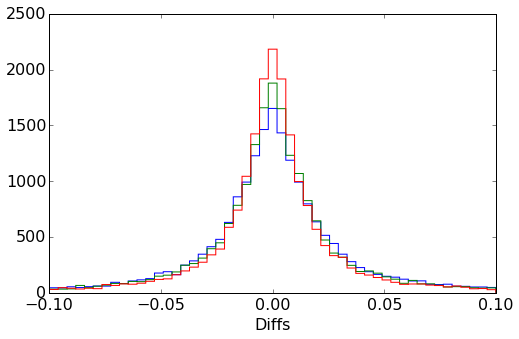

In [15]:
bins = 51
diff_limits = (-0.1, 0.1)
f, ax = plt.subplots()
diff20 = (samples[20][20]["m"] - truth["m"]) / truth["m"]
diff30 = (samples[30][20]["m"] - truth["m"]) / truth["m"]
diff80 = (samples[80][40]["m"][:20000] - truth["m"]) / truth["m"]
h = plt.hist(diff20, bins, diff_limits, histtype="step")
h = plt.hist(diff30, bins, diff_limits, histtype="step")
h = plt.hist(diff80, bins, diff_limits, histtype="step")
print(ufloat(diff20.mean(), np.sqrt(diff20.std())))
print(ufloat(diff30.mean(), np.sqrt(diff30.std())))
plt.xlim(diff_limits)
plt.xlabel(r'Diffs')

#### 1.3 $\eta_\nu$ Distribution flat vs gaussian

(-4, 6)

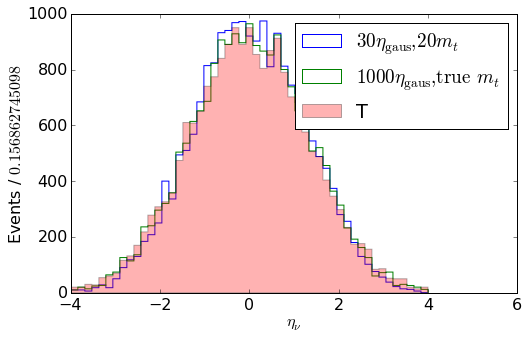

In [19]:
eta_limits = (-4, 4)
f, ax = plt.subplots()
# h = plt.hist(uniform_sample[20][20]["t_neutrino_eta"], bins, eta_limits, histtype="step", label=r'$20\eta_\mathrm{flat},20m_t$')
# h = plt.hist(samples[20][20]["t_neutrino_eta"], bins, eta_limits, histtype="step", label=r'$20\eta_\mathrm{gaus},20m_t$')
# h = plt.hist(uniform_sample[30][20]["t_neutrino_eta"], bins, eta_limits, histtype="step", label=r'$30\eta_\mathrm{flat},20m_t$')
h = plt.hist(samples[30][20]["t_neutrino_eta"], bins, eta_limits, histtype="step", label=r'$30\eta_\mathrm{gaus},20m_t$')
h = plt.hist(samples[1000][1]["nu_eta"], bins, eta_limits, histtype="step", label=r'$1000\eta_\mathrm{gaus},\mathrm{true}\,m_t$')
h = plt.hist(truth["t_neutrino_eta"], bins, eta_limits, histtype="stepfilled", alpha=.3, label=r'T')
#plt.plot(eta_xs, gauss(eta_xs, *eta_pars), '--', label=r'$\eta_\nu$-dist')
plt.legend(loc='best')
plt.xlabel(r'$\eta_\nu$')
plt.ylabel(r'Events / ${}$'.format(binwidth(h)))
plt.xlim(-4,6)

In [ ]:
bins = 151
diff_limits = (-5, 5)
var = "t_neutrino_eta"
f, ax = plt.subplots()
diff20 = (samples[20][20][var] - truth[var])
diff80 = (samples[80][40]["nu_eta"][:20000] - truth[var])
h = plt.hist(diff20, bins, diff_limits, histtype="step", label='20')
h = plt.hist(diff80, bins, diff_limits, histtype="step", label='80')

binnedX = h[1][1:] - (h[1][1] - h[1][0]) / 2
c, m = curve_fit(gauss, binnedX, h[0], p0=[0, 2, 1000])
mean = ufloat(c[0], m[0,0])
sigma = ufloat(c[1], m[1,1])

xs = np.linspace(*diff_limits, num=200)
plt.plot(xs, gauss(xs, *c), '--')

print(sigma)
print(diff20.mean(), np.sqrt(diff20.std()))

plt.xlim(diff_limits)
plt.xlabel(r'$\Delta \eta_\nu$')
plt.legend()

In [ ]:
plt.clf()
h = plt.hist2d((truth[var])[selection], (samples[20][20][var])[selection], 50, ((-1, 1), (-1, 1)))

####2. Using the true $\eta_\nu$, $m_t$ and combination instead of sampling

In [ ]:
f, ax = plt.subplots()
h = ax.hist(nw_true_mt["m"], bins, m_limits, histtype="step", label=r'true $m_t$')
ax.hist(nw_true_eta["m"], bins, m_limits, histtype="step", label=r'true $\eta_\nu$')
ax.hist(nw_true_eta_mt["m"], bins, m_limits, histtype="step", label=r'true $\eta_\nu + m_t$')
ax.hist(truth["m"], bins, m_limits, histtype="stepfilled", alpha=0.3, edgecolor="none", label=r'Truth')
plt.xlabel(r'$m_t\,/\,\mathrm{GeV}$')
plt.ylabel(r'Events / ${}\,\mathrm{{GeV}}$'.format(binwidth(h)))
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('build/plots/notebooks/nw-truth-eta-PDGmt.pdf')

####3. Adding true charge of $b$, true $m_b$ and true $m_{W^\pm}$ to combination of true $\eta_\nu$, $m_t$

In [ ]:
f, ax = plt.subplots()
plt.hist(nw_true_eta_mt["m"], bins, m_limits, histtype="stepfilled", alpha=0.3, label=r'true $\eta_\nu + m_t$')
h = plt.hist(nw_true_eta_mt_wm["m"], bins, m_limits, histtype="step", label=r"$+m_{W^\pm}$")
plt.hist(nw_true_eta_mt_mb["m"], bins, m_limits, histtype="step", label=r"$+m_b$")
plt.hist(nw_true_eta_mt_bcharge["m"], bins, m_limits, histtype="step", label=r"$+b$")
# plt.hist(nw_true_eta_mt_bc_wm["m"], bins, m_limits, histtype="step", label=r"$+m_b +m_{W^\pm}$")
plt.legend(loc='best')
plt.xlabel(r'$m_t\,/\,\mathrm{GeV}$')
plt.ylabel('Events / ${}\,\mathrm{{GeV}}$'.format(binwidth(h)))
plt.tight_layout()
plt.savefig('build/plots/notebooks/nw-true-bw.pdf')

####4. Weight distributions

In [ ]:
bins = 50
limits = (0.0, 1.0)
f, ax = plt.subplots()
h = plt.hist(nw["t_weight"], bins, limits, histtype="step", label='NW', log=True)
plt.hist(nw_true_eta["t_weight"], bins, limits, histtype="step", label=r'$+\eta_\nu$', log=True)
plt.hist(nw_true_eta_mt["t_weight"], bins, limits, histtype="step", label=r'$+\eta_\nu +m_t$', log=True)
plt.hist(samples[80][40]["t_weight"], bins, limits, histtype="step", label=r'new', log=True)
plt.xlabel(r'$w_\mathrm{nw}$')
plt.ylabel(r'Events / ${:.2f}$'.format(binwidth(h)))
plt.legend(loc='upper center')
plt.tight_layout()

####5. $\eta$ vs. $w_\nu$

In [ ]:
f, ax = plt.subplots(2, 1, sharex=True)
eta = samples[80][40]["nu_eta"]
weight = samples[80][40]["t_weight"]
h0 = ax[0].hist2d(eta, weight, 200, ((-5, 5), (0.9, 1)))
ax[0].set_ylabel(r'$w_\mathrm{nw}$')
h1 = ax[1].hist2d(eta, weight, (200, 10), ((-5, 5), (0, 0.1)))
plt.xlabel(r'$\eta_\nu$')
plt.ylabel(r'$w_\mathrm{nw}$')
f.colorbar(h0[3], ax=ax[0])
f.colorbar(h1[3], ax=ax[1])

In [ ]:
f, ax = plt.subplots()
plt.scatter(eta, weight, marker='.', linewidths=0)
plt.ylim(0, 1)